In [6]:
import glob, matplotlib, re
# The uproot module is needed to convert the standard CERN file format (called "ROOT") to pandas dataframes.
import uproot, pandas
import numpy as np
# The following package is used to scan through different values of k and find the optimal value using the gap
# and gap* statistic. More info here https://github.com/milesgranger/gap_statistic
from gap_statistic import OptimalK

# Beautification of plot utilities
from plotParams import varLabels, binnings, units
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

randomState = 5
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('default')
font = {'size':14}
matplotlib.rc('font', **font)

In [7]:
# The samples are in the standard file format used at CERN: ROOT.
# We will convert these to pandas dataframes with the uproot package.

# We will consider two new physics models (signal 700_400 and 1300_1) and the background.
# The desired outcome is that when we cluster these we will get three clusters: one for 1300_1, one 700_400, and one for background.
sigPath='/data/atlasfs02/a/users/whopkins/SheffieldNtuples_v21.2.71-SRABC-PostFAR-Signals/'
sigPaths = glob.glob(sigPath+'*TT_directTT_1300_1.*10201*p3712*')
sigPaths.extend(glob.glob(sigPath+'*TT_directTT_700_400.e6985_a875_r10201_p3712*'))
bkgPaths = glob.glob('/data/atlasfs02/a/users/whopkins/SheffieldNtuples_SRABC/*10201*.root')
treeName='NominalFixed'

# Only select variables that were used in the original signal regions that searched for these signals on ATLAS.
from stop0L import selections
srList = ['SRATT', 'SRATW', 'SRAT0', 'SRBTT', 'SRBTW', 'SRBT0']#, 'SRC1_5']
splitPat = '[><=]'
allCuts = []
for sr in srList:
    allCuts.extend([re.split(splitPat, cut.replace('(', '').replace(')', ''))[0].rstrip().lstrip() for cut in selections[sr].split("*")])
branches = sorted(list(set(allCuts)))
branches.append('pT_1jet')

# These branches are needed to weight the different components of the background correctly.
# In the end we will weight background and the two signals so that they have the same integral.
branches.append('LumiWeight')
branches.append('AnalysisWeight')

print(branches)

# Give the signal samples a reasonable name
sampLabels = []
for path in sigPaths:
    fName = path.split('/')[-1]
    
    firstSplitStr = 'directTT_';
    secondSplitStr = '.'
    if 'bWN' in fName:
        firstSplitStr = 'bWN_';
        secondSplitStr = '_Mad'
    sampLabels.append('sig_'+fName.split(firstSplitStr)[1].split(secondSplitStr)[0])

print('All available variables')

sigData = {}
# The lumi is technically not needed here since we will rescale everything anyway.
# However, it is useful for comparing the original analysis (manually designed) with
# the result of the k-means (can k-means separate the samples as strongly as we can?).
lumi = 139000
for path, sampName in zip(sigPaths, sampLabels):
    tree = uproot.open(path)[treeName]
    data = tree.arrays(branches, library='pd')
    data['sampName'] = sampName
    data['weight'] = data['AnalysisWeight']*data['LumiWeight']*lumi
    sigData[sampName] = data

bkgData = []
weights = []
for path in bkgPaths:
    fName = path.split('/')[-1]
    sampName = fName.split('.')[2]
    inF = uproot.open(path)
    tree = inF[treeName]
    if 'pT_1jet' not in sorted(tree.keys()):
        continue
    data = tree.arrays(branches, library='pd')
    data['weight'] = data['AnalysisWeight']*data['LumiWeight']*lumi
    data['sampName'] = 'bkg'
    bkgData.append(data)
dataList = list(sigData.values())
dataList.extend(bkgData)

allSamps = pandas.concat(dataList)
sampLabels.append('bkg')
print(sampLabels)

['MT2Chi2', 'MTbmax', 'MTbmin', 'dRb1b2', 'dphimin4', 'eT_miss', 'flav_1fatjet_kt12', 'flav_2fatjet_kt12', 'm_1fatjet_kt12', 'm_1fatjet_kt8', 'm_2fatjet_kt12', 'metsigST', 'nbaselineLep', 'nj_good', 'num_bjets', 'pT_2jet', 'pT_4jet', 'passMETtriggers', 'passtauveto', 'pT_1jet', 'LumiWeight', 'AnalysisWeight']
All available variables


['sig_1300_1', 'sig_700_400', 'bkg']


In [8]:
# Make a basic preselection before clustering.
# There are already selections made to produce this simulated data so not much to do here.
rawDataPresel = allSamps[(allSamps['nbaselineLep']==0)].copy()
sampSizes = {}
sampYields = {}

# We want the weighted integral to be equal for all samples.
for sampName in sampLabels:
    sampIndex = rawDataPresel['sampName']==sampName
    sampSizes[sampName] = rawDataPresel[sampIndex].shape[0]
    sampYields[sampName] = rawDataPresel[sampIndex].weight.sum()
print(sampSizes)
print(sampYields)
maxYieldKey = max(sampYields, key=lambda k: sampYields[k])
print(maxYieldKey)
minSampSize = min(sampSizes.values())
tempDFs = [] 
for sampName in sampYields:
    sampIndex = rawDataPresel['sampName']==sampName
    rawDataPresel.loc[sampIndex, 'weight'] *= (sampYields[maxYieldKey]/sampYields[sampName])

{'sig_1300_1': 2125, 'sig_700_400': 1384, 'bkg': 45481}
{'sig_1300_1': 26.260953896144343, 'sig_700_400': 762.1685215256098, 'bkg': 1922.3421223132377}
bkg


In [9]:
# The veto list is a remnant from I threw all variables at k-means.
# For this test we will use two variables known to discriminate background from the two signals (each variable performing better for one fo the signals).
vetoList=['passMETtriggers', 'passtauveto', 'nbaselineLep', 'eT_miss', 
          'flav_1fatjet_kt12', 'flav_2fatjet_kt12', 'num_bjets', 'NbV', 'NjV', 'nj_good']
trainBranches = [branch for branch in branches if branch not in vetoList]
print(trainBranches)
trainBranches = ['dRb1b2', 'metsigST',]


['MT2Chi2', 'MTbmax', 'MTbmin', 'dRb1b2', 'dphimin4', 'm_1fatjet_kt12', 'm_1fatjet_kt8', 'm_2fatjet_kt12', 'metsigST', 'pT_2jet', 'pT_4jet', 'pT_1jet', 'LumiWeight', 'AnalysisWeight']


['sig_1300_1', 'sig_700_400', 'bkg']


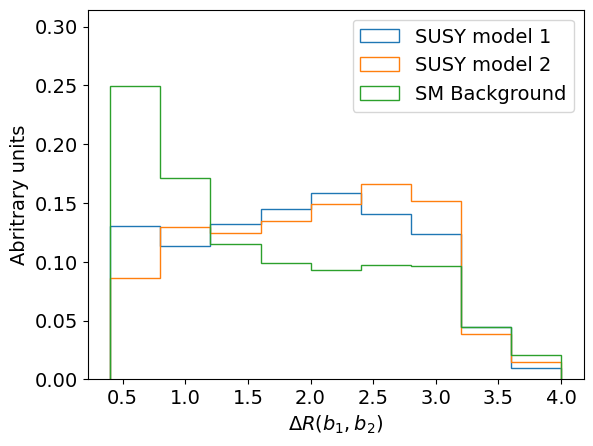

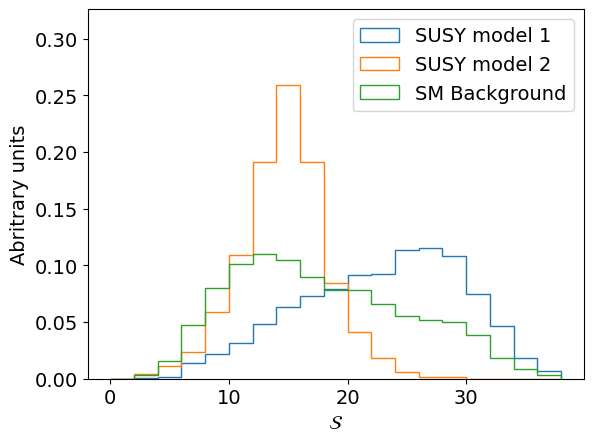

In [10]:
# Let's make histograms of the variables used for clustering to have an idea
# of how the different samples look.
prettySampNames = {
    'bkg':'SM Background',
}
for sampNum, samp in enumerate(sampLabels):
    if 'sig' in samp:
        stopMass = samp.split('_')[1]
        lspMass = samp.split('_')[2]
        #prettySampNames[samp] = '$m_{\\tilde{t}}, m_{\\chi}$='+stopMass+', '+lspMass+' GeV'
        prettySampNames[samp] = f'SUSY model {sampNum+1}' 
for varName in trainBranches:
    fig, ax = plt.subplots()
    for samp in sampLabels:
        sampData = rawDataPresel[rawDataPresel['sampName'] == samp]
        weights = np.ones((sampData.shape[0]))/sampData.shape[0]
        if varName in binnings:
            plt.hist(sampData[varName], histtype='step', bins=binnings[varName], label=prettySampNames[samp], weights=weights)
        else:
            plt.hist(sampData[varName], histtype='step', label=prettySampNames[samp], weights=weights)
        
    ax.set_ylabel('Abritrary units')
    xlabel = varName
    if varName in varLabels:
        xlabel = varLabels[varName]
        for varType in units:
            if varType in varName:
                xlabel += f' [{units[varType]}]'
                break
    ax.set_xlabel(xlabel)
    ax.legend(loc=0)
    ax.set_ylim(0, ax.get_ylim()[1]*1.2)
    plt.savefig(f'{varName}.pdf', bbox_inches='tight')
    plt.savefig(f'{varName}.svg', bbox_inches='tight')
print(sampLabels)

In [11]:
# The scales of the input data can vary drastically (e.g. 0.4-4 for dRbb to 1500 GeV for MET).
# Let's remove these differences in scale to fascilitate the clustering (I'm not entirely sure it makes a big difference here).
scaledData = rawDataPresel.copy(deep=True)
scalers = {}
for column in trainBranches:
    scalers[column] = MinMaxScaler()
    scaledData[[column]] = scalers[column].fit_transform(scaledData[[column]])
clusteringData = scaledData[trainBranches]


In [12]:
# Needed to define my own clusterer to add the weights when using OptimalK. Not needed when using KMeans from scikit-learn directly.
def clusterer(X: np.ndarray, k: int, weights: np.ndarray, random_state: int):
    """
    Function to wrap a sklearn model as a clusterer for OptimalK
    First two arguments are always the data matrix, and k. 
    Third argument are sample weights so that we can weight background correctly.
    """
    m = KMeans(random_state=random_state)
    m.fit(X, sample_weight=weights)
    return m.cluster_centers_, m.predict(X, sample_weight=weights)

k_max=20
optimalK = OptimalK(n_jobs=10, clusterer=clusterer, clusterer_kwargs={"random_state":randomState, 'weights':rawDataPresel.weight})
n_clusters = optimalK(clusteringData.to_numpy(), cluster_array=np.arange(1, k_max+1))

3


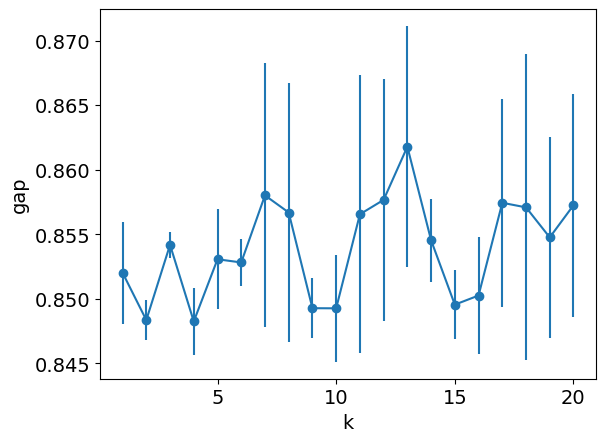

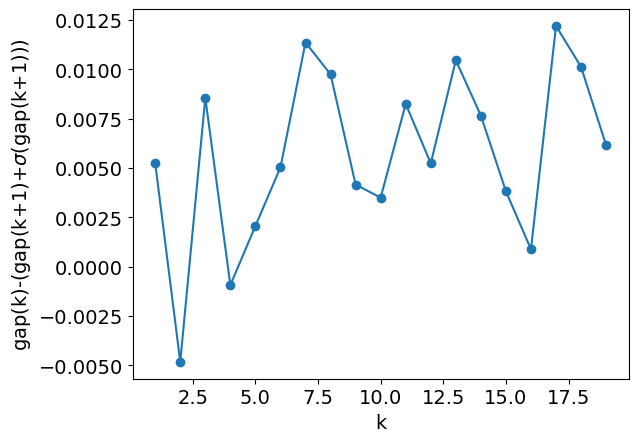

In [13]:
# Find the optimal K
fig, ax = plt.subplots()
plt.errorbar(range(1, k_max+1), optimalK.gap_df['gap_value'], yerr=optimalK.gap_df['sk'], fmt='-o')
plt.ylabel('gap')
plt.xlabel('k')
plt.savefig("gap_new.svg",bbox_inches='tight')
plt.savefig("gap_new.pdf",bbox_inches='tight')
fig, ax = plt.subplots()
plt.plot(range(1, k_max+1), optimalK.gap_df['diff'], '-o')
plt.ylabel('gap(k)-(gap(k+1)+$\sigma$(gap(k+1)))')
plt.xlabel('k')
plt.savefig("diff.svg",bbox_inches='tight')
plt.savefig("diff.pdf",bbox_inches='tight')
# Get the best k which is the first k for which gap(k)-(gap(k+1)-sigma(k+1))>=0
bestK = -1;
for diffI in range(optimalK.gap_df['diff'].shape[0]):
    if optimalK.gap_df['diff'][diffI] > 0 and diffI+1 > 1:
        bestK = diffI+1;
        break;
print(bestK)

13


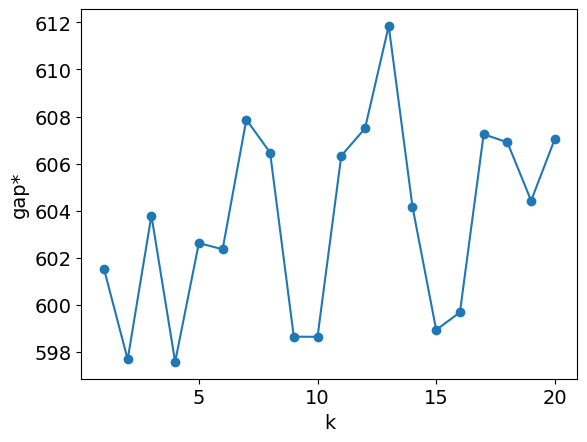

In [14]:
# Repeat for gap*. The outcome is not expected to be consistent but it's interesting to see alternatives.
fig, ax = plt.subplots()
plt.errorbar(range(1, k_max+1), optimalK.gap_df['gap*'], fmt='-o')
plt.ylabel('gap*')
plt.xlabel('k')
plt.savefig("gapstar.svg",bbox_inches='tight')
plt.savefig("gapstar.pdf",bbox_inches='tight')

# Get the best k which is the first k for which gap(k)-(gap(k+1)-sigma(k+1))>=0
bestKStar = np.argmax(optimalK.gap_df['gap*'])+1
print(bestKStar)
# The gap statistics overestimates the number of clusters when there are many clusters.
if bestK >=5:
    bestK = bestKStar

In [15]:
# Get the centroids and lables.
bestNClus = bestK
Kmean = KMeans(n_clusters=bestNClus, random_state=randomState)
Kmean.fit(clusteringData.to_numpy(), sample_weight=rawDataPresel.weight)
centroids = Kmean.cluster_centers_
clusLabels = Kmean.labels_
print(centroids)

[[0.45988395 0.27596463]
 [0.13614629 0.26464409]
 [0.23229312 0.53710695]]


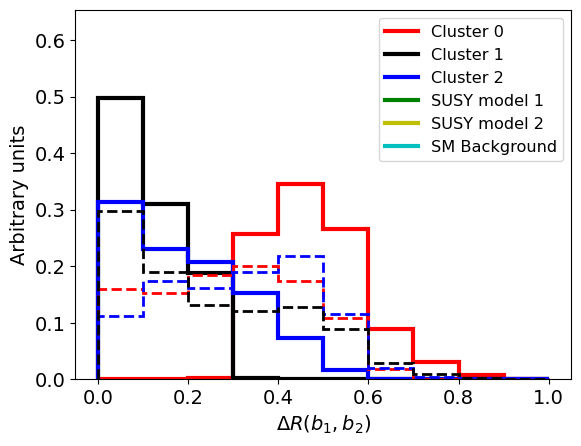

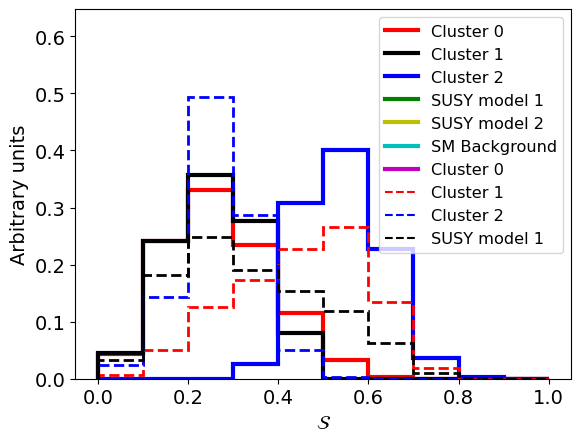

In [16]:
# Plot the 1D histograms of the data points belonging to various clusters
markers = ['s', 'P', 'o']
sampColors = ['r','b', 'k']
clusColors = ['r','k', 'b', 'g', 'y', 'c', 'm']
legHandles = []
for clusColor in clusColors:
    legHandles.append(matplotlib.lines.Line2D([], [], c=clusColor, linewidth=3))
for sampColor in sampColors:
    legHandles.append(matplotlib.lines.Line2D([], [], c=sampColor, linestyle='dashed'))
minFracOfTotal = 0.1
labels = []
bins = [0.1*i for i in range(11)]
for varName in trainBranches:
    fig, ax = plt.subplots()
    for clusI in range(bestNClus):
        clusData = clusteringData[clusLabels==clusI]
        # Don't bother with clusters that are poorly represented ()
        if clusData.shape[0]/clusteringData.shape[0] < minFracOfTotal:
            continue
        plt.hist(clusData[varName], bins=bins, histtype='step', weights=np.ones(clusData[varName].shape[0])/clusData[varName].shape[0], label=f"Cluster {clusI}", color=clusColors[clusI], linewidth=3)
        labels.append(f"Cluster {clusI}")
    for color, sampLabel in zip(sampColors,sampLabels):
        y_values, bin_edges = np.histogram(scaledData[rawDataPresel.sampName==sampLabel][varName], bins=bins)
        bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
        #plt.plot(bin_centers, y_values/scaledData[rawDataPresel.sampName==sampLabel][varName].shape[0], color+'o', label=prettySampNames[sampLabel])
        plt.hist(scaledData[rawDataPresel.sampName==sampLabel][varName], bins=bins, histtype='step', weights=np.ones(scaledData[rawDataPresel.sampName==sampLabel][varName].shape[0])/scaledData[rawDataPresel.sampName==sampLabel][varName].shape[0], color=color, linestyle='dashed', linewidth=2)
        labels.append(prettySampNames[sampLabel])

    xlabel = varName
    if varName in varLabels:
        xlabel = varLabels[varName]
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Arbitrary units')
    ax.set_ylim(0, ax.get_ylim()[1]*1.25)
    ax.legend(ncol=1, handles=legHandles, labels=labels, fontsize='small')
    plt.savefig(f"{varName}_postclustering.svg",bbox_inches='tight')
    plt.savefig(f"{varName}_postclustering.pdf",bbox_inches='tight')


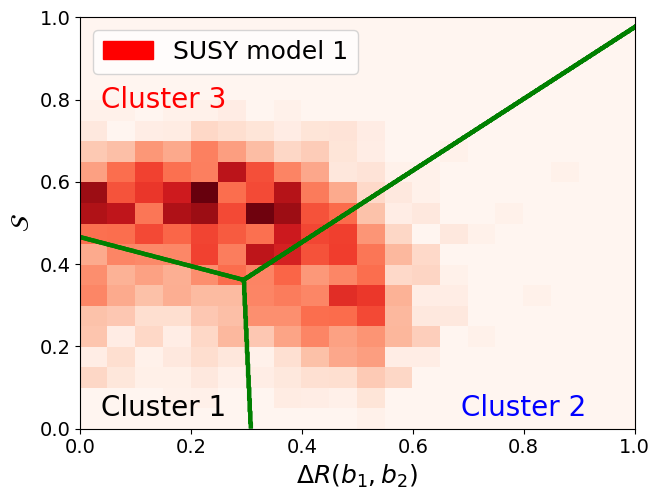

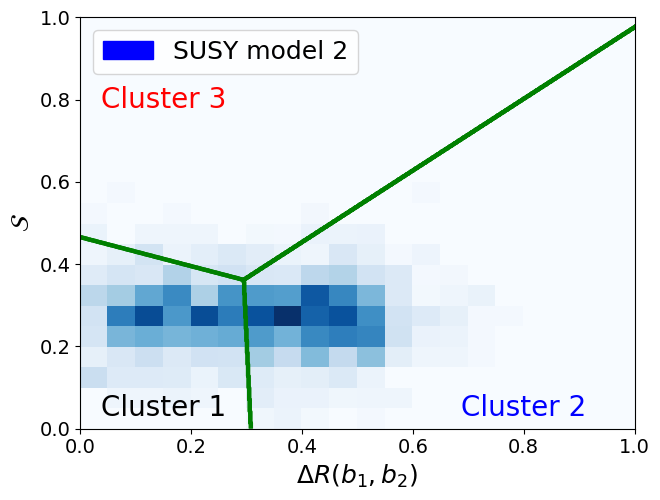

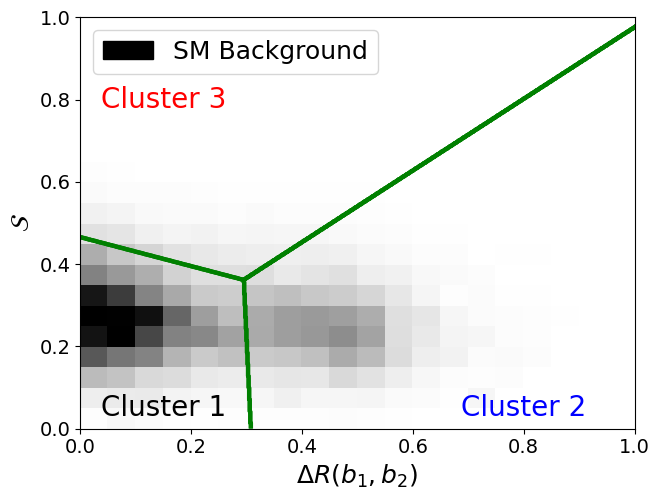

In [17]:
# Plot the 2D histograms (since we only have two variables that we are clustering in)
# and also plot the cluster boundaries.

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .001     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = 0,1.1
y_min, y_max = 0,1.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
# Obtain labels for each point in mesh. Use last trained model.
z = Kmean.predict(np.c_[xx.ravel(), yy.ravel()])
z = z.reshape(xx.shape)
# Put the result into a color plot

bins2d = [[i*.05 for i in range(21)], [i*.05 for i in range(21)]]
colorMaps = [plt.cm.Reds, plt.cm.Blues, plt.cm.Greys]
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

for color, cmap, sampLabel in zip(sampColors, colorMaps, sampLabels):
    fig, ax = plt.subplots()
    scaledSampData = scaledData[rawDataPresel.sampName==sampLabel]
    sampData = rawDataPresel[rawDataPresel.sampName==sampLabel]
    plt.hist2d(scaledSampData['dRb1b2'], scaledSampData['metsigST'], bins=bins2d, cmap=cmap, weights=sampData.weight)
    plt.contour(xx, yy, z, levels=3, colors='g', linewidths=[3])
    cluster1Text = ax.text(0.15, 0.05, 'Cluster 1', ha="center", va="center", color=sampColors[2], fontsize=20)
    cluster2Text = ax.text(0.8, 0.05, 'Cluster 2', ha="center", va="center", color=sampColors[1], fontsize=20)
    cluster3Text = ax.text(0.15, 0.8, 'Cluster 3', ha="center", va="center", color=sampColors[0], fontsize=20)
    legHandles = [mpatches.Patch(color=color, label=prettySampNames[sampLabel])]

    ax.set_ylim(0, 1)
    ax.set_xlim(0, 1)
    fontsize=18
    ax.set_xlabel(varLabels['dRb1b2'], fontsize=fontsize)
    ax.set_ylabel(varLabels['metsigST'], fontsize=fontsize)
    ax.legend(ncol=1, handles=legHandles, fontsize=fontsize, loc=2)
    plt.tight_layout(pad=0.0)
    plt.margins(0,0)
    plt.savefig(f"complex_{sampLabel}_2DHist_postclustering.svg",bbox_inches='tight', pad_inches=0)
    plt.savefig(f"complex_{sampLabel}_2DHist_postclustering.pdf",bbox_inches='tight', pad_inches=0)

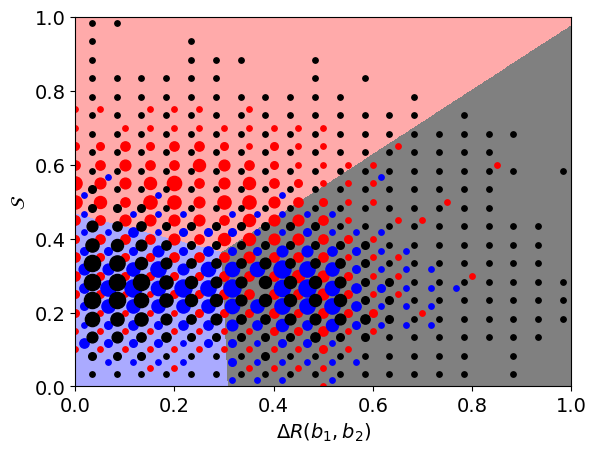

In [21]:
# Some variations of the above plots that I found less enlightening.
maxZ = 0
hist = {}
clusterColors=['grey', '#AAAAFF', '#FFAAAA']
cmap_light = ListedColormap(clusterColors)
for color, marker, sampLabel in zip(colorMaps, markers, sampLabels):
    scaledSampData = scaledData[rawDataPresel.sampName==sampLabel]
    sampData = rawDataPresel[rawDataPresel.sampName==sampLabel]
    temp = np.histogram2d(scaledSampData['dRb1b2'], scaledSampData['metsigST'], bins=bins2d, weights=sampData.weight/np.sum(sampData.weight))
    x = (temp[1][:-1] + temp[1][1:]) / 2
    y = (temp[2][:-1] + temp[2][1:]) / 2
    xy = np.meshgrid(x, y)[0]
    tempMaxZ = np.max(temp[0])
    if tempMaxZ > maxZ:
        maxZ = np.max(temp[0])
    hist[sampLabel] = temp[0]

nZBins = 11
zBins = np.arange(0, maxZ, maxZ/nZBins)
legHandles = [matplotlib.lines.Line2D([], [], c='k', linewidth=3), matplotlib.lines.Line2D([], [], c='b', linewidth=3), matplotlib.lines.Line2D([], [], c='r', linewidth=3),
              matplotlib.lines.Line2D([], [], c='r', linestyle='dashed'), matplotlib.lines.Line2D([], [], c='b', linestyle='dashed'), matplotlib.lines.Line2D([], [], c='k', linestyle='dashed')]
minFracOfTotal = 0.1
fig, ax = plt.subplots()
xBinSize = x[1]-x[0]
yBinSize = y[1]-y[0]
nSamps = len(sampColors)
plt.imshow(z, interpolation='nearest', extent=(xx.min(), xx.max(), yy.min(), yy.max()), cmap=cmap_light, aspect='auto', origin='lower')
for color, marker, sampLabel, sampI in zip(sampColors, markers, sampLabels, range(nSamps)):
    for i in range(1, nZBins):
        condition = (hist[sampLabel] > zBins[i-1]) & (hist[sampLabel] < zBins[i])
        tempXY = np.where(condition)
        plt.scatter(x[tempXY[0]]-xBinSize/2+(xBinSize/nSamps)*sampI, y[tempXY[1]]-yBinSize/2+(yBinSize/nSamps)*sampI, label=f"{sampLabel}", color=color, s=i*15, marker='o')#, facecolors='none')
ax.set_ylim(0, 1)
ax.set_xlim(0, 1)
ax.set_xlabel(varLabels['dRb1b2'])
ax.set_ylabel(varLabels['metsigST'])
#ax.legend(ncol=1, handles=legHandles, labels=labels, fontsize='small')
plt.savefig(f"complex_scatter_postclustering.svg",bbox_inches='tight')
plt.savefig(f"complex_scatter_postclustering.pdf",bbox_inches='tight')

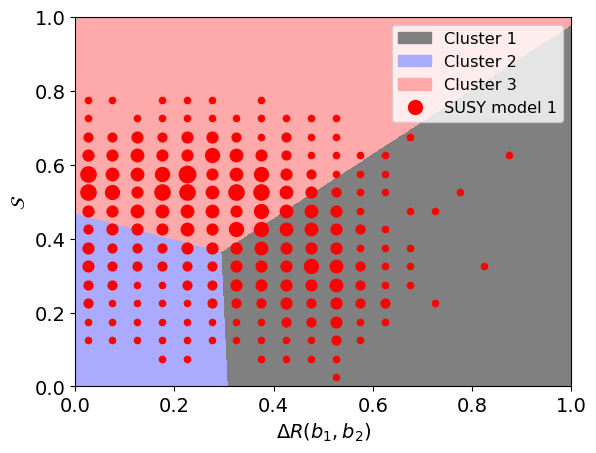

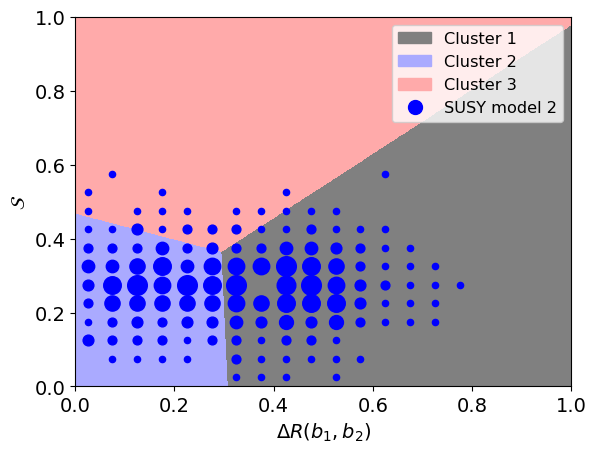

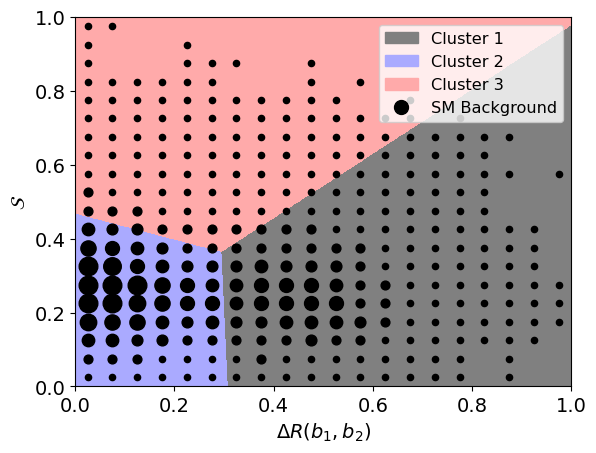

In [22]:
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
for color, marker, sampLabel, sampI in zip(sampColors, markers, sampLabels, range(nSamps)):
    fig, ax = plt.subplots()
    plt.imshow(z, interpolation='nearest', extent=(xx.min(), xx.max(), yy.min(), yy.max()), cmap=cmap_light, aspect='auto', origin='lower')
    legHandles = [mpatches.Patch(color=clusterColors[0], label='Cluster 1'),
                  mpatches.Patch(color=clusterColors[1], label='Cluster 2'),
                  mpatches.Patch(color=clusterColors[2], label='Cluster 3'),
                  mlines.Line2D([], [], color=color, marker='o', linestyle='None', markersize=10, label=prettySampNames[sampLabel]) ]

    for i in range(1, nZBins):
        condition = (hist[sampLabel] > zBins[i-1]) & (hist[sampLabel] < zBins[i])
        tempXY = np.where(condition)
        plt.scatter(x[tempXY[0]], y[tempXY[1]], label=f"{sampLabel}", color=color, s=i*20, marker='o')#, facecolors='none')
    ax.set_ylim(0, 1)
    ax.set_xlim(0, 1)
    ax.legend(ncol=1, handles=legHandles, fontsize='small', loc=1)
    ax.set_xlabel(varLabels['dRb1b2'])
    ax.set_ylabel(varLabels['metsigST'])
    plt.savefig(f"{sampLabel}_complex_scatter_postclustering.svg",bbox_inches='tight')
    plt.savefig(f"{sampLabel}_complex_scatter_postclustering.pdf",bbox_inches='tight')

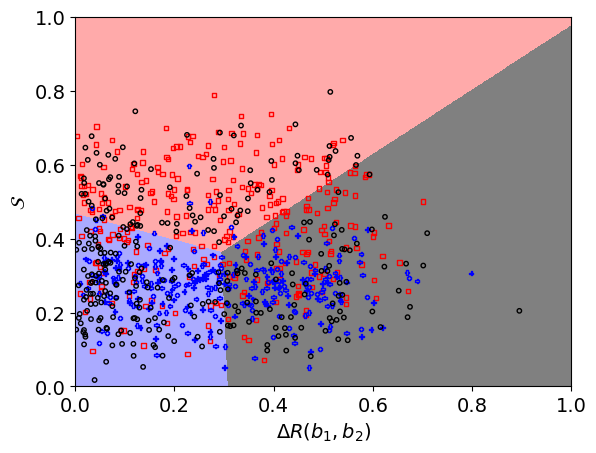

In [23]:
sampColors = ['r','b', 'k']
from matplotlib.colors import ListedColormap
markers = ['s', 'P', 'o']
fig, ax = plt.subplots()
plt.imshow(z, interpolation='nearest', extent=(xx.min(), xx.max(), yy.min(), yy.max()), cmap=cmap_light, aspect='auto', origin='lower')
nsamp = 300
for color, marker, sampLabel in zip(sampColors,markers, sampLabels):
    plt.scatter(scaledData[rawDataPresel.sampName==sampLabel]['dRb1b2'].sample(n=nsamp), scaledData[rawDataPresel.sampName==sampLabel]['metsigST'].sample(n=nsamp), label=f"{sampLabel}", color=color, s=10, marker=marker, facecolors='none')
    labels.append(f"Cluster {clusI}")
ax.set_xlabel(varLabels['dRb1b2'])
ax.set_ylabel(varLabels['metsigST'])
ax.set_ylim(0, 1)
ax.set_xlim(0, 1)

#ax.legend(ncol=1, handles=legHandles, labels=labels, fontsize='small')
plt.savefig(f"scatter_postclustering.svg",bbox_inches='tight')
plt.savefig(f"scatter_postclustering.pdf",bbox_inches='tight')